### LSTM Model Loop with Skill Score calculation

File recreated on 6/10/2025 for the "updated" model. 

I will start with a 14 day model. 

File re-upload for reproduction using fixed data. 

In [1]:
##import cell makes its appearance once again...
%matplotlib inline
##so-called "math" related imports
#from netCDF4 import Dataset as ncread
import numpy as np
import pandas as pd
import math
import random
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import TimeSeriesSplit
import xarray as xr

import pickle

import warnings
warnings.filterwarnings("ignore")

##plotting related imports
import matplotlib.pyplot as plt

#import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

tf.device('/physical_device:GPU:0')

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec

import shap
import pylab
#tf.compat.v1.disable_eager_execution()
#import investigate

2026-01-15 18:12:53.562779: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 18:12:53.615161: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-15 18:12:53.615243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-15 18:12:53.616664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-15 18:12:53.628684: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from StatScores import BSS
from StatScores import RAS_two
from StatScores import PAS_two

### Inputs.

In [3]:
##load in solvers for PC analysis to get the PCs for the model itself. 

In [4]:
# load input solvers
infile = open("U_14.p","rb",)
U_PC = pickle.load(infile)  ##pv on an isentropic surface, 350
infile.close()

infile = open("EHF_14.p","rb",)
EHF_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

infile = open("GPH_14.p","rb",)
GPH_PC = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
infile.close()

##remove PC 1
U_PC = U_PC[:, 1:]
EHF_PC = EHF_PC[:, 1:]
GPH_PC = GPH_PC[:, 1:]

U_PC.shape

(9238, 9)

In [14]:
##create one array of PCs
inputvar = np.concatenate((U_PC,EHF_PC,GPH_PC),axis=1) 
inp1 = inputvar.reshape(9238,62)

##make pandas dataframe for RF
input = pd.DataFrame(inp1)

#number of PCs
U_pcs   = range(2, 11)   
EHF_pcs = range(2, 46)  
GPH_pcs = range(2, 11) 

col_names = ([f"U{pc}" for pc in U_pcs] + [f"EHF{pc}" for pc in EHF_pcs] +[f"GPH{pc}" for pc in GPH_pcs])
input.columns = col_names
#inp

In [20]:
#create pd datafram of selected feature columns.
sele_ind_df = input[['U3', 'GPH3', 'U2', 'GPH10', 'GPH5', 'EHF2', 'EHF19', 'GPH6', 'EHF24',
       'EHF14', 'EHF29', 'EHF7', 'EHF11', 'EHF8', 'EHF17', 'EHF15', 'EHF4',
       'GPH4', 'EHF22', 'EHF16', 'EHF32', 'EHF20', 'U5', 'EHF3', 'EHF25', 'U6',
       'EHF43']]
n_features = len(sele_ind_df.iloc[0])
n_features

27

In [21]:
input.shape

(9238, 62)

In [22]:
#turn input array into (# samples, 14 days, 10 features)
sele_ind_data = sele_ind_df.values
sele_ind_data1 = sele_ind_data.reshape(62,149,n_features)

### Outputs. 

These locations probably need to be changed

In [23]:
#load output data
infile = open("../data/eur_anomtemps_reduced.p","rb")
output = pickle.load(infile) 
infile.close()

output.shape

(9238,)

In [24]:
#load climo data
infile = open("../data/eur_climoprob_reduced.p","rb",)
climo = pickle.load(infile) 
infile.close()

In [25]:
lead = 135

temp = output.reshape(62, 149)
temp = temp[:, 14:]

climo = climo.reshape(62, 149,2)
climo = climo[:, 14:, :]
#climo = climo.reshape(8370,2)

print("input: ",sele_ind_data1.shape)
print("climo: ",climo.shape)
print("output: ",temp.shape)

input:  (62, 149, 27)
climo:  (62, 135, 2)
output:  (62, 135)


In [26]:
#create timeseries data arrays for PCs 
#was 122 and 14 for the 14 day window. 

new_input =  np.empty((62,lead,14,n_features))
new_output = np.empty((62,lead))
new_climo = np.empty((62,lead,2))

for i in range(0,62):
    for j in range(0,lead):
        new_input[i,j,:,:] = sele_ind_data1[i,j:j+14,:]
        new_output[i,j] = temp[i,j]
        new_climo[i,j] = climo[i,j,:]

In [27]:
new_input = np.array(new_input)
new_climo = np.array(new_climo.reshape(62*lead,2))
new_output = np.array(new_output)

print("input: ",new_input.shape)
print("climo: ",new_climo.shape)
print("output: ",new_output.shape)

input:  (62, 135, 14, 27)
climo:  (8370, 2)
output:  (62, 135)


In [28]:
frac_ind = round((10*lead))
frac_end = round((62*lead)-frac_ind)

print("testing and validation size: ",frac_ind)
print("training size: ",frac_end)

testing and validation size:  1350
training size:  7020


In [29]:
##Set X_all and Y_all datasets
X_all = np.copy(new_input.reshape((62*lead),14,n_features))
Y_all = np.copy(new_output.flatten())

##training data partition out
X_tri = X_all[:frac_end,:]
Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes = X_all[frac_end:,:]
Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

print(Y_all.shape)

(8370, 2)


In [30]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [31]:
##number of input nodes
numb_int = X_all.shape[1:]
#this defines the 2-d shape used by the lstm model.
print("shape of lstm input: ",numb_int)

shape of lstm input:  (14, 27)


In [32]:
########
#CHANGE BASED ON NUMBER OF FOLDS FOR TIMESERIES SPLIT

repeat = 2
split = 7

#n = repeat*split
n = 100

In [33]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [34]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [35]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = [] 

##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((n,))
BSS_val= np.empty((n,))
BSS_train= np.empty((n,))
BSS_test= np.empty((n,))
BSS_90= np.empty((n,))

BSS_avg= np.empty((n,))
BSS_30= np.empty((n,))
BSS_70= np.empty((n,))

##RAS and PAS Arrays
Prec_all= np.empty((n,2))
Rec_all= np.empty((n,2))

Prec_val= np.empty((n,2))
Rec_val= np.empty((n,2))

Prec_train= np.empty((n,2))
Rec_train= np.empty((n,2))

Prec_test= np.empty((n,2))
Rec_test= np.empty((n,2))

##FOR SHAP
cat_shaps = np.empty((n,2,20))
class0_agg = np.empty((n,300,20))
class1_agg = np.empty((n,300,20))
shap_out = np.empty((n,2,300,14,20))

In [36]:
##empty lists for ACC scores 
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

In [37]:
##probabilities
p_test = []
p_train = []
p_val = []

p_mid = []
p_90 = []
p_30 = []
p_70 = []

##correct positive
posXtest = []
#false positive
FposXtest = []
#correct negative
negXtest = []
#false negative
FnegXtest = []

index90 = []
indexmin = []
indexmid = []
indexmax = []

##correct positive
percpos = []
#false positive
percFpos = []
#correct negative
percneg = []
#false negative
percFneg = []

### Model Architecture. 

In [38]:
######
batch_size = 64
epochs = 20
shuffle = True
verbose = 0 #0 returns no apoch info, 2 does

In [39]:
#DEFINITION OF MODEL ITSELF
def basic_LSTM(ntimestep, nfeature, n1, n2, n3, rl1, rl3, lr):  
    input_tensor = Input(shape=(ntimestep, nfeature))
    
    layer1 = layers.RNN(
        layers.LSTMCell(n1, activation='tanh', use_bias=True,
                          kernel_initializer='glorot_uniform',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1)),
        return_sequences=False)(input_tensor)
    #layer1, alfa = AttentionWithContext()(layer1)
    #layer1 = Addition()(layer1)
    
    #layer2 = layers.RNN(
        #layers.LSTMCell(n2, activation='tanh', use_bias=True,
                          #kernel_initializer='glorot_uniform',
                          #kernel_regularizer=keras.regularizers.l2(l2= rl1)))(layer1)
    
    layer3 = layers.Dense(n3, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl3))(layer1)

    output_tensor = layers.Dense(2, activation='softmax',)(layer3)

    model = Model(input_tensor, output_tensor)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    #decay_rate = lr / epochs
    #momentum = 0.9

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[keras.metrics.categorical_accuracy],)
                            
    return model

In [40]:
##Early Stopping Condition, if desired
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True,verbose=1)

In [41]:
## create loop for cross validation
for l in range(0,n):
    print("#######################################")
    print("CV ",l)
    tf.keras.backend.clear_session()
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 15% window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]
    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    ##calculate class weights on remaining training data
    #class_weight = class_weight_creator(Y_tr)
    class_weight = {0 : 1.0, 1 : 1.79}
    
    
    ##same partitioning for climo data
    climo_train1 = new_climo[0:start,:]
    climo_train2 = new_climo[end:frac_end,:]
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##pause, calculate climo probabilities
    climo_val = new_climo[start:end,:]
    climo_test = new_climo[frac_end:,:]
    
    #initalize model
    model = basic_LSTM(numb_int[0],numb_int[1], 64, 16, 16, 0.3, 0.2, 0.0006466)

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, verbose=verbose, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
    
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    
    p_train.extend(pred_train)
    p_val.extend(pred_val)
    p_test.extend(pred_test)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    
    ##BRIER SKILL SCORE
    BSS_all[l] = BSS(Y_all,pred)
    BSS_val[l] = BSS(Y_val,pred_val)
    BSS_train[l] = BSS(Y_tr,pred_train)
    BSS_test[l] = BSS(Y_tes,pred_test) 
    
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, new_climo, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))
    ##Greater than 90 BSS
    climo_90 = climo_test[great90]
    
    BSS_90[l] = BSS(test90_norm,test90)
    p_90.extend(test90)
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative

    for j in range(len(great90)):
        index = great90[j]

        if pred_test[index, 1] > pred_test[index, 0] and Y_tes[index, 1] == 1:
            correct_pos.append(index)
        elif pred_test[index, 0] > pred_test[index, 1] and Y_tes[index, 0] == 1:
            correct_neg.append(index)
        elif pred_test[index, 1] > pred_test[index, 0] and Y_tes[index, 0] == 1:
            false_pos.append(index)
        elif pred_test[index, 0] > pred_test[index, 1] and Y_tes[index, 1] == 1:
            false_neg.append(index)

    ##correct positive
    posXtest.extend(correct_pos)
    #false positive
    FposXtest.extend(false_pos)
    #correct negative
    negXtest.extend(correct_neg)
    #false negative
    FnegXtest.extend(false_neg)
    
    percpos.append(len(correct_pos)/len(great90))
    #false positive
    percFpos.append(len(false_pos)/len(great90))
    #correct negative
    percneg.append(len(correct_neg)/len(great90))
    #false negative
    percFneg.append(len(false_neg)/len(great90))


    ##############################3
    
    #AVERAGE QUANT
    qmin = np.min(pred_test,axis=0)
    q30 = np.percentile(pred_test,30,axis=0) ##30th percentile of test
    q70 = np.percentile(pred_test,70,axis=0) ##70th percentile of test
    qmax = np.max(pred_test,axis=0)
    
    ##mid percentile acc
    mid = [i for i, row in enumerate(pred_test) if (row[0] >= q30[0] and row[0] <= q70[0] ) or (row[1] >= q30[1] and row[1] <= q70[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_mid = pred_test[mid]
    test_mid_norm = Y_tes[mid]
    
    BSS_avg[l] = BSS(test_mid_norm,test_mid)
    p_mid.extend(test_mid)
    
    #0-30
    minimum = [i for i, row in enumerate(pred_test) if (row[0] >= qmin[0] and row[0] < q30[0] ) or (row[1] >= qmin[1] and row[1] < q30[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_minimum = pred_test[minimum]
    test_minimum_norm = Y_tes[minimum]
    
    BSS_30[l] = BSS(test_minimum_norm,test_minimum)
    p_30.extend(test_minimum)
    
    #70-100
    maximum = [i for i, row in enumerate(pred_test) if (row[0] > q70[0] and row[0] <= qmax[0] ) or (row[1] > q70[1] and row[1] <= qmax[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test_maximum = pred_test[maximum]
    test_maximum_norm = Y_tes[maximum]
    
    BSS_70[l] = BSS(test_maximum_norm,test_maximum)
    p_70.extend(test_maximum)
    
    ####_______SAVE INDICES _______
    index90.extend(great90)
    indexmin.extend(minimum)
    indexmid.extend(mid)
    indexmax.extend(maximum)

#######################################
CV  0
Restoring model weights from the end of the best epoch: 11.
Epoch 14: early stopping
43/43 [==============================] - 0s 3ms/step
#######################################
CV  1
Restoring model weights from the end of the best epoch: 14.
Epoch 17: early stopping
43/43 [==============================] - 0s 3ms/step
#######################################
CV  2
Restoring model weights from the end of the best epoch: 17.
Epoch 20: early stopping
43/43 [==============================] - 0s 4ms/step
#######################################
CV  3
Restoring model weights from the end of the best epoch: 9.
Epoch 12: early stopping
43/43 [==============================] - 0s 4ms/step
#######################################
CV  4
Restoring model weights from the end of the best epoch: 10.
Epoch 13: early stopping
43/43 [==============================] - 0s 3ms/step
#######################################
CV  5
Restoring model weights from the en

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [42]:
##correct positive
posXtest = np.array(posXtest)
#false positive
FposXtest = np.array(FposXtest)
#correct negative
negXtest = np.array(negXtest)
#false negative
FnegXtest = np.array(FnegXtest)

print(f'Average Num. of 10% Confident and Correct Postive Predictions: {np.mean(percpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and Correct Negative Predictions: {np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Postive Predictions: {np.mean(percFpos)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Negative Predictions: {np.mean(percFneg)* 100:.2f}%')
print('#######################################################################')
print(f'Average Num. of 10% Confident and Correct Predictions: {np.mean(percpos)* 100 + np.mean(percneg)* 100:.2f}%')
print(f'Average Num. of 10% Confident and FALSE Predictions: {np.mean(percFpos)* 100 +np.mean(percFneg)* 100:.2f}%')

Average Num. of 10% Confident and Correct Postive Predictions: 35.67%
Average Num. of 10% Confident and Correct Negative Predictions: 28.76%
Average Num. of 10% Confident and FALSE Postive Predictions: 14.33%
Average Num. of 10% Confident and FALSE Negative Predictions: 21.24%
#######################################################################
Average Num. of 10% Confident and Correct Predictions: 64.43%
Average Num. of 10% Confident and FALSE Predictions: 35.57%


### Skill Score Distributions. 

### Percentile ACC Plots.

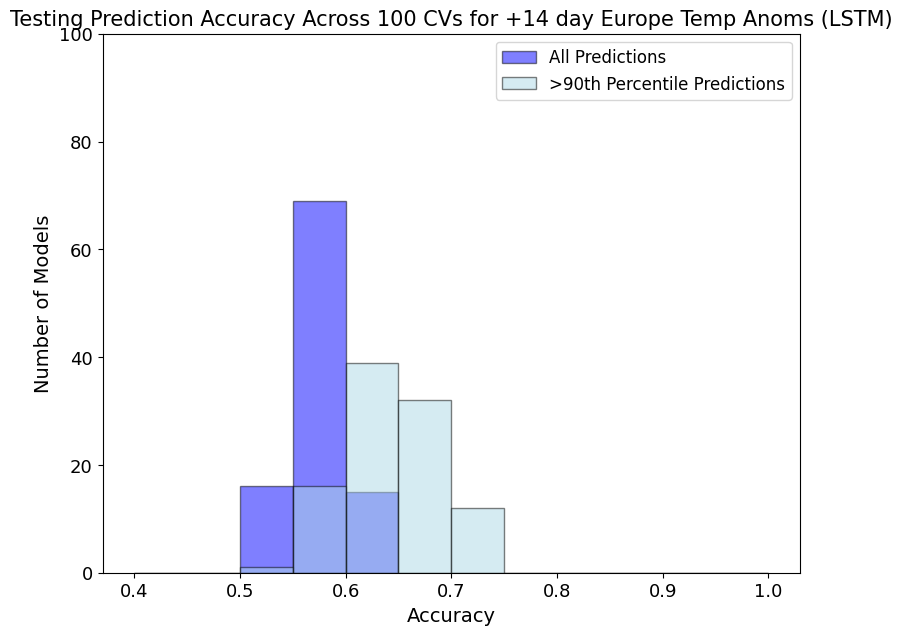

In [44]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
fig = plt.figure(figsize=(9,7))
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy', fontsize =14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylim(0,100)
plt.ylabel('Number of Models', fontsize =14)
plt.legend(fontsize = 12)
plt.title('Testing Prediction Accuracy Across 100 CVs for +14 day Europe Temp Anoms (LSTM)', fontsize =15)
plt.savefig("EOFLSTM_EUR14_ACCtesting.png",bbox_inches = 'tight')

In [43]:
## testing print avg BSS/RAS/PAS
def F1_score(RAS,PAS):
    F1 = np.nanmean(((2*RAS*PAS)/(RAS+PAS)))
    return F1
#___________________________________________#

print("_____________________________________________________________________")
print(f"Brier Skill Score (Test): {np.nanmean(BSS_test,axis=0):.4f}")
print("_____________________________________________________________________")
print("Recall and Precision: Neg Cat")
print("#########")
print(f"Recall Accuracy Score (Test): {np.nanmean(Rec_test[:,0],axis=0):.4f}")
print(f"Precision Accuracy Score (Test): {np.nanmean(Prec_test[:,0],axis=0):.4f}")
print(f"F1 Score (Test): {F1_score(Rec_test[:,0],Prec_test[:,0]):.4f}")
print("_____________________________________________________________________")
print("Recall and Precision: Pos Cat")
print("#########")
print(f"Recall Accuracy Score (Test): {np.nanmean(Rec_test[:,1],axis=0):.4f}")
print(f"Precision Accuracy Score (Train): {np.nanmean(Prec_train[:,1],axis=0):.4f}")
print(f"F1 Score (Test): {F1_score(Rec_test[:,1],Prec_test[:,1]):.4f}")

_____________________________________________________________________
Brier Skill Score (Test): 0.0173
_____________________________________________________________________
Recall and Precision: Neg Cat
#########
Recall Accuracy Score (Test): 0.4847
Precision Accuracy Score (Test): 0.5902
F1 Score (Test): 0.5240
_____________________________________________________________________
Recall and Precision: Pos Cat
#########
Recall Accuracy Score (Test): 0.6607
Precision Accuracy Score (Train): 0.5754
F1 Score (Test): 0.6052
